In this notebook, we first compute the symmetry groups of the 0-surgeries knots from our census and in a second step algorithmically construct the Piccirillo duals of all knots with unknotting number 1 in an attempt to show that the knots have the same traces.

In [1]:
import snappy
import time
import itertools

def all_positive(manifold):
    '''
    Checks if the solution type of a triangulation is positive.
    '''
    return manifold.solution_type() == 'all tetrahedra positively oriented'

def find_positive_triangulations(manifold,number=1,tries=100):
    '''
    Searches for one triangulation with a positive solution type.
    (Or if number is set to a different value also for different such triangulations.)
    '''
    M = manifold.copy()
    pos_triangulations=[]
    for i in range(tries):
        if all_positive(M):
            pos_triangulations.append(M)
            if len(pos_triangulations)==number:
                return pos_triangulations
            break
        M.randomize()
    for d in M.dual_curves(max_segments=500):
        X = M.drill(d)
        X = X.filled_triangulation()
        X.dehn_fill((1,0),-1)
        for i in range(tries):
            if all_positive(X):
                pos_triangulations.append(X)
                if len(pos_triangulations)==number:
                    return pos_triangulations
                break
            X.randomize()

    # In the closed case, here is another trick.
    if all(not c for c in M.cusp_info('is_complete')):
        for i in range(tries):
            # Drills out a random edge
            X = M.__class__(M.filled_triangulation())
            if all_positive(X):
                pos_triangulations.append(X)
                if len(pos_triangulations)==number:
                    return pos_triangulations
            break
            M.randomize()
    return pos_triangulations


def better_symmetry_group(M,index=100):
    '''
    This function computes the symmetry group of the input manifold. 
    If the second entry is True it is proven to be the symmetry group.
    '''
    pos_triang=find_positive_triangulations(M,tries=index)
    if pos_triang==[]:
        full=False
        randomizeCount=0
        while randomizeCount<index and full==False:
            try:
                S=M.symmetry_group()
                full=S.is_full_group()
                M.randomize()
                randomizeCount=randomizeCount+1
            except (ValueError, RuntimeError, snappy.SnapPeaFatalError):
                M.randomize()
                randomizeCount=randomizeCount+1
        try:
            return (S,full)
        except NameError:
            return ('unclear',False)
    X=pos_triang[0]
    full=False
    randomizeCount=0
    while randomizeCount<index and full==False:
        try:
            S=X.symmetry_group()
            full=S.is_full_group()
            X.randomize()
            randomizeCount=randomizeCount+1
        except (ValueError, RuntimeError, snappy.SnapPeaFatalError):
            X.randomize()
            randomizeCount=randomizeCount+1
    if full==True:
        return (S,full)
    pos_triang=find_positive_triangulations(M,number=index,tries=index)
    if pos_triang==[]:
        try:
            return (S,full)
        except NameError:
            return ('unclear',False)
    for X in pos_triang:
        full=False
        randomizeCount=0
        while randomizeCount<index and full==False:
            try:
                S=X.symmetry_group()
                full=S.is_full_group()
                X.randomize()
                randomizeCount=randomizeCount+1
            except (ValueError, RuntimeError, snappy.SnapPeaFatalError):
                X.randomize()
                randomizeCount=randomizeCount+1
        if full==True:
            return (S,full)
    try:
        return (S,full)
    except NameError:
        return ('unclear',False)
    
def conj_symmetry_group(M,index=100):
    pos_triang=find_positive_triangulations(M,tries=index)
    if pos_triang==[]:
        randomizeCount=0
        while randomizeCount<index:
            try:
                S=M.symmetry_group()
                full=S.is_full_group()
                return (S,full)
            except (ValueError, RuntimeError, snappy.SnapPeaFatalError):
                M.randomize()
                randomizeCount=randomizeCount+1
        return ('unclear',False)
    X=pos_triang[0]
    randomizeCount=0
    while randomizeCount<index:
        try:
            S=X.symmetry_group()
            full=S.is_full_group()
            return (S,full)
        except (ValueError, RuntimeError, snappy.SnapPeaFatalError):
            X.randomize()
            randomizeCount=randomizeCount+1
    pos_triang=find_positive_triangulations(M,number=index,tries=index)
    if pos_triang==[]:
        return ('unclear',False)
    for X in pos_triang:
        randomizeCount=0
        while randomizeCount<index:
            try:
                S=X.symmetry_group()
                full=S.is_full_group()
                return (S,full)
            except (ValueError, RuntimeError, snappy.SnapPeaFatalError):
                X.randomize()
                randomizeCount=randomizeCount+1
    return ('unclear',False)

def is_unknot(PD,index=10):
    '''
    Returns True if it represents the unknot and False if the group looks not free abelian.
    '''
    K=snappy.Link(PD).exterior()
    if K.fundamental_group().num_generators()==1:
        return True
    for i in range(index):
        K.randomize()
        if K.fundamental_group().num_generators()==1:
            return True
    return False

def is_trivial_Jones(PD):
    '''
    Checks if the knot has trivial Jones.
    '''
    K=snappy.Link(PD)
    jones=K.jones_polynomial()
    if jones==1:
        return True
    return False

def change_crossing(PD_code,crossing):
    '''
    Changes the crossing.
    '''
    (a,b,c,d)=crossing
    PD_code.remove(crossing)
    PD_code.append((d,a,b,c))
    return PD_code

def unknotting_number_of_diagram(PD):
    '''
    Returns the unknotting number of the diagram. 
    Warning: Is slow for large unknotting numbers.
    '''
    start_time=time.time()
    for depth in range(1,len(PD)):
        crossing_list=list(itertools.combinations(PD, depth))
        for crossings in crossing_list:
            PD_new=PD.copy()
            for c in crossings:
                PD_new=change_crossing(PD_new,c)
            if is_unknot(PD_new):
                print('An unknotting sequence:',crossings)
                return depth
            else:
                alex=snappy.Link(PD_new).exterior().alexander_polynomial()
                if alex==1:
                    if is_trivial_Jones(PD_new):
                        if is_unknot(PD_new,index=1000)==False:
                            print('A sequence to a knot with trivial Jones polynomial:',crossings)
                        else:
                            print('An unknotting sequence:',crossings)
                            return depth 

def find_unknotting_crossings(PD):
    '''
    Returns the unknotting crossings of a diagram.
    '''
    unknotting_crossings=[]
    for c in PD:
        PD_new=PD.copy()
        PD_new=change_crossing(PD_new,c)
        if is_unknot(PD_new,index=1000):
            unknotting_crossings.append(c)
        else:
            alex=snappy.Link(PD_new).exterior().alexander_polynomial()
            if alex==1:
                if is_trivial_Jones(PD_new):
                    print('A sequence to a knot with trivial Jones polynomial:',crossings)
    return unknotting_crossings


def sign_of_crossing(cros):
    '''
    Returns the sign of a crossing. (In a PD code that is ordered.)
    '''
    if cros[1]==0 and cros[3]!=1:
        return 1
    if cros[3]==0and cros[1]!=1:
        return -1
    if cros[1]>cros[3]:
        return +1
    return -1

def take_mirror(PD):
    '''Returns the mirror of the input diagram.'''
    PD_mirror=[]
    for c in PD:
        PD_mirror.append((c[1],c[2],c[3],c[0]))
    return PD_mirror

def number_of_strands(PD_code):
    '''
    Returns the number of strands in a diagram.
    '''
    X=[]
    for cros in PD_code:
        X=X+[x for x in cros]
    return max(X)+1 

def create_Piccirillo_RGB_link(PD,unknotting_cros):
    '''
    Takes a PD code and an unknotting crossing and creates a PD code of the Piccirillo RGB link.
    '''
    if sign_of_crossing(unknotting_cros)==-1:
        (PD,unknotting_cros)=(take_mirror(PD),(unknotting_cros[1],unknotting_cros[2],unknotting_cros[3],unknotting_cros[0]))
    m=number_of_strands(PD)
    (a,b,c,d)=unknotting_cros
    PD_new=PD.copy()
    PD_new.remove(unknotting_cros)
    PD_new.append((m+4,m+1,d,a))
    PD_new.append((m+4,m+5,m+3,m+8))  
    PD_new.append((m+5,b,m+6,m+3)) 
    PD_new.append((m+6,m+10,m+7,m+9)) 
    PD_new.append((m+9,m+7,m+12,m+8)) 
    PD_new.append((m+12,m+2,m+11,m+1)) 
    PD_new.append((m+2,m+10,c,m+11)) 
    return PD_new

def better_is_isometric_to(X,Y,return_isometries=False,index=100,try_hard=False):
    """
    Returns True if X and Y are isometric.
    Returns False if X and Y have different homologies.
     """ 
    if return_isometries==False:
        w='unclear'
        if X.homology()!=Y.homology():
            return False
        for i in (0,index):
            try:
                w=X.is_isometric_to(Y)
            except (RuntimeError,snappy.SnapPeaFatalError):
                pass
            if w==True:
                return w
            X.randomize()
            Y.randomize()
            i=i+1
        if try_hard:
            pos_triang_X=find_positive_triangulations(X,number=1,tries=index)
            pos_triang_Y=find_positive_triangulations(Y,number=1,tries=index)
            for X in pos_triang_X:
                for Y in pos_triang_Y:
                    w=better_is_isometric_to(X,Y,index=100,try_hard=False)
                    if w==True:
                        return w
        return 'unclear'
    if return_isometries==True:
        w=False
        if X.homology()!=Y.homology():
            return []
        for i in (0,index):
            try:
                w=X.is_isometric_to(Y,return_isometries)
            except (RuntimeError,snappy.SnapPeaFatalError):
                pass
            if w!=False:
                return w
            X.randomize()
            Y.randomize()
            i=i+1
        if try_hard:
            pos_triang_X=find_positive_triangulations(X,number=10,tries=index)
            pos_triang_Y=find_positive_triangulations(Y,number=10,tries=index)
            for X in pos_triang_X:
                for Y in pos_triang_Y:
                    w=better_is_isometric_to(X,Y,return_isometries,index=100,try_hard=False)
                    if w!=False:
                        return w
        return []

def create_Piccirillo_duals(PD,try_hard=False):
    '''
    Takes as input a PD code of an unknotting number one diagram and returns triangulations of the Piccirillo duals.
    '''
    duals=[]
    K=snappy.Link(PD).exterior()
    cros=find_unknotting_crossings(PD)
    if cros==[]:
        return duals
    
    for c in cros:
        RGB=snappy.Link(create_Piccirillo_RGB_link(PD,c)).exterior()

        RGB.dehn_fill([(0,0),(0,1),(0,1)])
        B=RGB.filled_triangulation()
        if better_is_isometric_to(K,B,try_hard=try_hard)==True:
            RGB.dehn_fill([(-2,1),(0,0),(0,1)])
            G=RGB.filled_triangulation()
            if better_is_isometric_to(G,B,try_hard=try_hard)!=True:
                is_in_duals=False
                for Y in duals:
                    if better_is_isometric_to(Y,G)==True:
                        is_in_duals=True
                        break
                if is_in_duals==False:
                    duals.append(G)

            RGB.dehn_fill([(-2,1),(0,1),(0,0)])
            G=RGB.filled_triangulation()
            if better_is_isometric_to(G,B,try_hard=try_hard)!=True:
                is_in_duals=False
                for Y in duals:
                    if better_is_isometric_to(Y,G)==True:
                        is_in_duals=True
                        break
                if is_in_duals==False:
                    duals.append(G)

        RGB.dehn_fill([(0,1),(0,0),(0,1)])
        B=RGB.filled_triangulation()
        if better_is_isometric_to(K,B,try_hard=try_hard)==True:
            RGB.dehn_fill([(0,0),(-2,1),(0,1)])
            G=RGB.filled_triangulation()
            if better_is_isometric_to(G,B,try_hard=try_hard)!=True:
                is_in_duals=False
                for Y in duals:
                    if better_is_isometric_to(Y,G)==True:
                        is_in_duals=True
                        break
                if is_in_duals==False:
                    duals.append(G)

            RGB.dehn_fill([(0,1),(-2,1),(0,0)])
            G=RGB.filled_triangulation()
            if better_is_isometric_to(G,B,try_hard=try_hard)!=True:
                is_in_duals=False
                for Y in duals:
                    if better_is_isometric_to(Y,G)==True:
                        is_in_duals=True
                        break
                if is_in_duals==False:
                    duals.append(G)

        RGB.dehn_fill([(0,1),(0,1),(0,0)])
        B=RGB.filled_triangulation()
        if better_is_isometric_to(K,B,try_hard=False)==True:
            RGB.dehn_fill([(0,1),(0,0),(-2,1)])
            G=RGB.filled_triangulation()
            if better_is_isometric_to(G,B,try_hard=try_hard)!=True:
                is_in_duals=False
                for Y in duals:
                    if better_is_isometric_to(Y,G)==True:
                        is_in_duals=True
                        break
                if is_in_duals==False:
                    duals.append(G)

            RGB.dehn_fill([(0,0),(0,1),(-2,1)])
            G=RGB.filled_triangulation()
            if better_is_isometric_to(G,B,try_hard=try_hard)!=True:
                is_in_duals=False
                for Y in duals:
                    if better_is_isometric_to(Y,G)==True:
                        is_in_duals=True
                        break
                if is_in_duals==False:
                    duals.append(G)
                    
    return duals
    

We load the census of friends.

In [2]:
friends=[
['K6a1','19nh_000000078'],
['K10n10','t11532'],
['K11n49','K15n103488'], 
['K12n309','K14n14254'], 
['K13n469','K13n469'], 
['K9n4','o9_34801'],
['K11n38','v3093'], 
['K11n116','t12607'], 
['K13n572','K15n89587'], 
['K13n1021','K15n101402'], 
['K14n3155','K14n3155'], 
['K13n2527','K15n9379'], 
['K12n318','o9_39433'], 
['K15n19499','K15n153789'], 
['K13n3158','o9_41909'],
['K14n3155','t11462'], 
['K14n3155','t11462'], 
['t11532','o9_43446'],
['K12n200','t11748'], 
['K10n10','o9_43446'], 
['K11n49','o9_42735'], 
['K14n3611','o9_27542'], 
['K15n94464','o9_40081'], 
['v2869','t12388'], 
['t11462','t11462'], 
['K13n1021','o9_34908'], 
['K15n19499','o9_31828'], 
['K15n153789','o9_31828'], 
['K15n103488','o9_42735'], 
['K15n101402','o9_34908'], 
['K14n5084','o9_37547'], 
['t10974','o9_39967'], 
['t07281','o9_39806'], 
['t07281','o9_34949'], 
['t11900','o9_40803'], 
['o9_41058','o9_41058'], 
['o9_22951','o9_22951'], 
['o9_39806','o9_34949']]

PD_19nh_000000078=[(20, 0, 21, 37), (0, 36, 1, 35), (14, 1, 15, 2), (31, 3, 32, 2), (3, 31, 4, 30), (4, 15, 5, 16), (16, 5, 17, 6), (29, 7, 30, 6), (7, 29, 8, 28), (8, 17, 9, 18), (18, 9, 19, 10), (27, 11, 28, 10), (11, 27, 12, 26), (21, 13, 22, 12), (13, 35, 14, 34), (36, 20, 37, 19), (22, 25, 23, 26), (32, 23, 33, 24), (24, 33, 25, 34)]

In [3]:
len(friends)

38

First we compute their symmetry groups.

In [4]:
start_time=time.time()
for [x,y] in friends:
    K=snappy.Manifold(x)
    if y=='19nh_000000078':
        F=snappy.Link(PD_19nh_000000078).exterior()
    else:
        F=snappy.Manifold(y)
    K.dehn_fill(K.homological_longitude())
    F.dehn_fill(F.homological_longitude())
    SK=better_symmetry_group(K)
    SF=better_symmetry_group(F)
    print(x,y,SK,SF)
print('Total time taken:',(time.time()-start_time)/60,'minutes')

K6a1 19nh_000000078 (D4, True) (D4, True)
K10n10 t11532 (0, True) (0, True)
K11n49 K15n103488 (Z/2 + Z/2, True) (Z/2 + Z/2, True)
K12n309 K14n14254 (Z/2, True) (Z/2, True)
K13n469 K13n469 (at least Z/2, False) (at least Z/2, False)
K9n4 o9_34801 (Z/2 + Z/2, True) (Z/2 + Z/2, True)
K11n38 v3093 (Z/2 + Z/2, True) (Z/2 + Z/2, True)
K11n116 t12607 (Z/2, True) (Z/2, True)
K13n572 K15n89587 (Z/2 + Z/2, True) (Z/2 + Z/2, True)
K13n1021 K15n101402 (Z/2 + Z/2, True) (Z/2 + Z/2, True)
K14n3155 K14n3155 (D4, True) (D4, True)
K13n2527 K15n9379 (Z/2 + Z/2, True) (Z/2 + Z/2, True)
K12n318 o9_39433 (0, True) (0, True)
K15n19499 K15n153789 (at least Z/2, False) (unknown, False)
K13n3158 o9_41909 (Z/2, True) (Z/2, True)
K14n3155 t11462 (D4, True) (D4, True)
K14n3155 t11462 (D4, True) (D4, True)
t11532 o9_43446 (0, True) (0, True)
K12n200 t11748 (Z/2 + Z/2, True) (Z/2 + Z/2, True)
K10n10 o9_43446 (0, True) (0, True)
K11n49 o9_42735 (Z/2 + Z/2, True) (Z/2 + Z/2, True)
K14n3611 o9_27542 (at least Z/2, Fal

Next, we create (potential) minimal crossing diagrams of all knots.

In [5]:
start_time=time.time()
diagrams_friends=[]

for [x,y] in friends:
    try:
        K=snappy.Link(x)
    except:
        K=snappy.Manifold(x).exterior_to_link()
        K.simplify('global',type_III_limit=5000)
    if y=='19nh_000000078':
        F=snappy.Link(PD_19nh_000000078)
    else:
        try:
            F=snappy.Link(y)
        except:
            F=snappy.Manifold(y).exterior_to_link()
            F.simplify('global',type_III_limit=5000)
    print(x,len(K.PD_code()))
    print(y,len(F.PD_code()))
    print('----------')
    diagrams_friends.append([x,y,K.PD_code(),F.PD_code()])
print(diagrams_friends)    
print('Total time taken:',(time.time()-start_time)/60,'minutes')

K6a1 6
19nh_000000078 19
----------
K10n10 10
t11532 16
----------
K11n49 11
K15n103488 15
----------
K12n309 12
K14n14254 14
----------
K13n469 13
K13n469 13
----------
K9n4 9
o9_34801 18
----------
K11n38 11
v3093 16
----------
K11n116 11
t12607 17
----------
K13n572 13
K15n89587 15
----------
K13n1021 13
K15n101402 15
----------
K14n3155 14
K14n3155 14
----------
K13n2527 13
K15n9379 15
----------
K12n318 12
o9_39433 18
----------
K15n19499 15
K15n153789 15
----------
K13n3158 13
o9_41909 19
----------
K14n3155 14
t11462 20
----------
K14n3155 14
t11462 20
----------
t11532 16
o9_43446 28
----------
K12n200 12
t11748 23
----------
K10n10 10
o9_43446 28
----------
K11n49 11
o9_42735 27
----------
K14n3611 14
o9_27542 25
----------
K15n94464 15
o9_40081 24
----------
v2869 18
t12388 22
----------
t11462 20
t11462 20
----------
K13n1021 13
o9_34908 28
----------
K15n19499 15
o9_31828 26
----------
K15n153789 15
o9_31828 26
----------
K15n103488 15
o9_42735 27
----------
K15n101402 15
o

In [6]:
start_time=time.time()

unknotting_number_bounds=[]

for [x,y,PDK,PDF] in diagrams_friends:
    print(x)
    uK=unknotting_number_of_diagram(PDK)
    print('Unknotting bound of K:',uK)
    print(y)
    uF=unknotting_number_of_diagram(PDF)
    print('Unknotting bound of F:',uF)
    unknotting_number_bounds.append([x,y,PDK,PDF,uK,uF])
    print('------')


print('Total time taken:',(time.time()-start_time)/60,'minutes')

K6a1
An unknotting sequence: ((2, 0, 3, 11),)
Unknotting bound of K: 1
19nh_000000078
An unknotting sequence: ((20, 0, 21, 37), (27, 11, 28, 10), (32, 23, 33, 24))
Unknotting bound of F: 3
------
K10n10
An unknotting sequence: ((0, 6, 1, 5), (11, 16, 12, 17))
Unknotting bound of K: 2
t11532
An unknotting sequence: ((19, 28, 20, 29), (6, 30, 7, 29))
Unknotting bound of F: 2
------
K11n49
An unknotting sequence: ((17, 5, 18, 4), (15, 9, 16, 8))
Unknotting bound of K: 2
K15n103488
An unknotting sequence: ((0, 13, 1, 14), (6, 18, 7, 17))
Unknotting bound of F: 2
------
K12n309
An unknotting sequence: ((0, 8, 1, 7), (11, 18, 12, 19))
Unknotting bound of K: 2
K14n14254
An unknotting sequence: ((0, 10, 1, 9),)
Unknotting bound of F: 1
------
K13n469
An unknotting sequence: ((7, 19, 8, 18),)
Unknotting bound of K: 1
K13n469
An unknotting sequence: ((7, 19, 8, 18),)
Unknotting bound of F: 1
------
K9n4
An unknotting sequence: ((0, 7, 1, 8),)
Unknotting bound of K: 1
o9_34801
An unknotting seque

We create the Piccirillo RGB links of all knots that have unknotting number one.

In [7]:
start_time=time.time()

Piccirillo_RGB_links=[]

for [x,y,PDK,PDF] in diagrams_friends:
    if len(find_unknotting_crossings(PDK))>0:
        print(x)
        print('Has unknotting number 1. Number of unknotting crossings:',len(find_unknotting_crossings(PDK)))
        L=snappy.Link(create_Piccirillo_RGB_link(PDK,find_unknotting_crossings(PDK)[0]))
        print('The RGB link has PD code:',L.PD_code())
        Piccirillo_RGB_links.append([x,y,L.exterior()])
        print('------')
    if len(find_unknotting_crossings(PDF))>0:
        print(y)
        print('Has unknotting number 1. Number of unknotting crossings:',len(find_unknotting_crossings(PDF)))
        L=snappy.Link(create_Piccirillo_RGB_link(PDF,find_unknotting_crossings(PDF)[0]))
        print('The RGB link has PD code:',L.PD_code())
        Piccirillo_RGB_links.append([x,y,L.exterior()])
        print('------')
print('Total time taken:',(time.time()-start_time)/60,'minutes')

K6a1
Has unknotting number 1. Number of unknotting crossings: 2
The RGB link has PD code: [(0, 8, 1, 7), (8, 2, 9, 1), (10, 5, 11, 6), (6, 11, 7, 12), (12, 9, 13, 10), (13, 2, 14, 3), (14, 16, 15, 19), (16, 0, 17, 15), (17, 21, 18, 20), (23, 19, 20, 18), (22, 3, 23, 4), (4, 21, 5, 22)]
------
K14n14254
Has unknotting number 1. Number of unknotting crossings: 2
The RGB link has PD code: [(27, 1, 28, 0), (17, 29, 18, 28), (13, 27, 14, 26), (4, 26, 5, 25), (24, 16, 25, 15), (23, 7, 24, 6), (7, 23, 8, 22), (21, 9, 22, 8), (16, 9, 17, 10), (5, 14, 6, 15), (12, 3, 13, 4), (2, 11, 3, 12), (10, 1, 11, 2), (20, 31, 21, 0), (19, 34, 20, 35), (35, 18, 32, 19), (32, 36, 33, 39), (38, 34, 39, 33), (37, 31, 38, 30), (29, 37, 30, 36)]
------
K13n469
Has unknotting number 1. Number of unknotting crossings: 2
The RGB link has PD code: [(2, 0, 3, 29), (0, 6, 1, 5), (6, 2, 7, 1), (3, 12, 4, 13), (11, 4, 12, 5), (19, 11, 20, 10), (13, 28, 14, 29), (27, 14, 28, 15), (15, 26, 16, 27), (25, 16, 26, 17), (17,

In [8]:
Piccirillo_RGB_links

[['K6a1', '19nh_000000078', unnamed link(0,0)(0,0)(0,0)],
 ['K12n309', 'K14n14254', unnamed link(0,0)(0,0)(0,0)],
 ['K13n469', 'K13n469', unnamed link(0,0)(0,0)(0,0)],
 ['K13n469', 'K13n469', unnamed link(0,0)(0,0)(0,0)],
 ['K9n4', 'o9_34801', unnamed link(0,0)(0,0)(0,0)],
 ['K11n38', 'v3093', unnamed link(0,0)(0,0)(0,0)],
 ['K13n2527', 'K15n9379', unnamed link(0,0)(0,0)(0,0)],
 ['K14n3611', 'o9_27542', unnamed link(0,0)(0,0)(0,0)],
 ['K15n94464', 'o9_40081', unnamed link(0,0)(0,0)(0,0)],
 ['K15n19499', 'o9_31828', unnamed link(0,0)(0,0)(0,0)],
 ['K15n153789', 'o9_31828', unnamed link(0,0)(0,0)(0,0)],
 ['t07281', 'o9_39806', unnamed link(0,0)(0,0)(0,0)],
 ['t07281', 'o9_34949', unnamed link(0,0)(0,0)(0,0)],
 ['o9_22951', 'o9_22951', unnamed link(0,0)(0,0)(0,0)],
 ['o9_22951', 'o9_22951', unnamed link(0,0)(0,0)(0,0)]]

Next, we create the Piccirillo duals and check if they are the friends from our census. If yes that proves that the friends are actually 4-dimensional friends.

In [9]:
start_time=time.time()

Piccirillo_duals=[]
same_traces=[]

for [x,y,PDK,PDF] in diagrams_friends:
        duals=create_Piccirillo_duals(PDK)
        Piccirillo_duals.append([x,PDK,duals])
        print(x)
        print('Number of Piccirillo duals found:', len(duals))
        for X in duals:
            K=snappy.Link(PDF).exterior()
            if better_is_isometric_to(K,X,try_hard=False)==True:
                same_traces.append([x,y])
                print(x,' and ',y,' have the same traces.')
                
        duals=create_Piccirillo_duals(PDF)
        Piccirillo_duals.append([y,PDF,duals])
        print(y)
        print('Number of Piccirillo duals found:', len(duals))
        for X in duals:
            K=snappy.Link(PDK).exterior()
            if better_is_isometric_to(K,X,try_hard=False)==True:
                same_traces.append([x,y])
                print(x,' and ',y,' have the same traces.')


print('Total time taken:',(time.time()-start_time)/60,'minutes')

K6a1
Number of Piccirillo duals found: 1
K6a1  and  19nh_000000078  have the same traces.
19nh_000000078
Number of Piccirillo duals found: 0
K10n10
Number of Piccirillo duals found: 0
t11532
Number of Piccirillo duals found: 0
K11n49
Number of Piccirillo duals found: 0
K15n103488
Number of Piccirillo duals found: 0
K12n309
Number of Piccirillo duals found: 0
K14n14254
Number of Piccirillo duals found: 1
K13n469
Number of Piccirillo duals found: 0
K13n469
Number of Piccirillo duals found: 0
K9n4
Number of Piccirillo duals found: 1
K9n4  and  o9_34801  have the same traces.
o9_34801
Number of Piccirillo duals found: 0
K11n38
Number of Piccirillo duals found: 1
K11n38  and  v3093  have the same traces.
v3093
Number of Piccirillo duals found: 0
K11n116
Number of Piccirillo duals found: 0
t12607
Number of Piccirillo duals found: 0
K13n572
Number of Piccirillo duals found: 0
K15n89587
Number of Piccirillo duals found: 0
K13n1021
Number of Piccirillo duals found: 0
K15n101402
Number of Piccir

We handle the remaining exceptional cases seperately: There are K13n469 and o9_22951 that are both friends with their mirrors.

We start with K13n469.

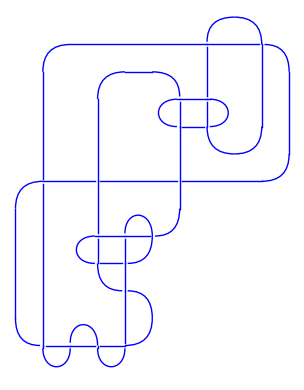

In [12]:
K=snappy.Manifold('K13n469')
D=K.link()

L=snappy.Link(create_Piccirillo_RGB_link(D.PD_code(),find_unknotting_crossings(D.PD_code())[0]))
L.sage_link().plot()

In [13]:
RGB=L.exterior()
RGB.dehn_fill([(0,1),(0,1),(0,0)])
B=RGB.filled_triangulation()
B.is_isometric_to(K,return_isometries=True)

[0 -> 0
 [-1 -2]
 [ 0 -1]
 Extends to link,
 0 -> 0
 [1 2]
 [0 1]
 Extends to link]

In [15]:
RGB.dehn_fill([(0,1),(0,0),(-2,1)])
G=RGB.filled_triangulation()
G.is_isometric_to(K,return_isometries=True)

[0 -> 0
 [1  0]
 [0 -1]
 Extends to link,
 0 -> 0
 [-1 0]
 [ 0 1]
 Extends to link]

This shows that B=K and G=-K and thus they have the same traces.

We continue with o9_22951.

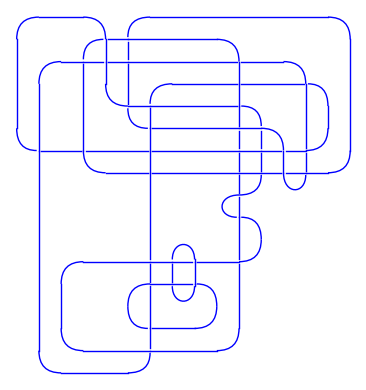

In [17]:
K=snappy.Manifold('o9_22951')
D=K.exterior_to_link()
D.simplify('global',type_III_limit=5000)

L=snappy.Link(create_Piccirillo_RGB_link(D.PD_code(),find_unknotting_crossings(D.PD_code())[0]))
L.sage_link().plot()

In [18]:
RGB=L.exterior()
RGB.dehn_fill([(0,1),(0,1),(0,0)])
B=RGB.filled_triangulation()
B.is_isometric_to(K,return_isometries=True)

[0 -> 0
 [1 1]
 [0 1]
 Extends to link,
 0 -> 0
 [-1 -1]
 [ 0 -1]
 Extends to link]

In [19]:
RGB.dehn_fill([(0,1),(0,0),(-2,1)])
G=RGB.filled_triangulation()
G.is_isometric_to(K,return_isometries=True)

[0 -> 0
 [1  1]
 [0 -1]
 Extends to link,
 0 -> 0
 [-1 -1]
 [ 0  1]
 Extends to link]

This shows that B=K and G=-K and thus they have the same traces.